<a href="https://colab.research.google.com/github/StevenVuong/MSc_Project/blob/master/p4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook is meant for the analysis and comparison of the different models and parameter selections**

In [4]:
# standard imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

# to mount our drive
from google.colab import drive

# import keras stuff
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, Convolution1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils, generic_utils, to_categorical
from keras.layers import LeakyReLU
from keras import regularizers

# to test our dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [6]:
# mount google drive
drive.mount('/content/gdrive')

os.chdir('/content')

# go to where the data is
print (os.listdir())
os.chdir('gdrive/My Drive/msc_project')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.config', 'gdrive', 'sample_data']


**Get our dataframe**

In [0]:
stored_name = '10_v0'

In [66]:
# read metrics file, format: [val_loss,val_acc, train_loss, train_acc, test_loss, test_acc]
metrics_df = pd.read_csv('stored_metrics_v2/metrics' +stored_name+'.csv', header=None)

# relabel headers
metrics_df.columns = ['val_loss', 'val_acc', 'train_loss', 'train_acc']
metrics_df.head()

,val_loss,val_acc,train_loss,train_acc
0,1.014767,0.588235,1.100225,0.526882
1,0.955466,0.500000,1.098543,0.511628
2,0.752972,0.600000,1.110667,0.447059
3,0.822675,0.625000,0.700887,0.722222
4,0.863308,0.600000,0.873539,0.600000


In [67]:
# aggregate so we have the averages of each batch
batch_mean_df = metrics_df.groupby(np.arange(len(metrics_df))//5).mean()

# only want to take the last 30 (we only trained for 30 epochs, filter noise)
batch_mean_df = batch_mean_df.tail(30)
batch_mean_df.head()

,val_loss,val_acc,train_loss,train_acc
0,0.881838,0.582647,0.976772,0.561558
1,0.813503,0.496912,0.912989,0.563490
2,0.809955,0.515980,0.705584,0.652272
3,0.723735,0.585245,0.615742,0.660070
4,0.631540,0.628125,0.436308,0.800323


**Below is the performance of our train/test/validation sets, quite impressive**

In [68]:
# get the final output (model at end)
batch_mean_df.iloc[-1,:]

val_loss      0.631540
val_acc       0.628125
train_loss    0.436308
train_acc     0.800323
Name: 4, dtype: float64

**Plot accuracy and noise for train/test/validation sets**

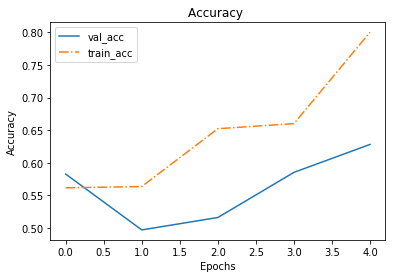

In [69]:
# plotting the accuracy
plt.plot(batch_mean_df.val_acc.values, label='val_acc', ls='-')
plt.plot(batch_mean_df.train_acc.values, label='train_acc', ls='-.')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy ')

plt.legend(loc='best')

plt.show()

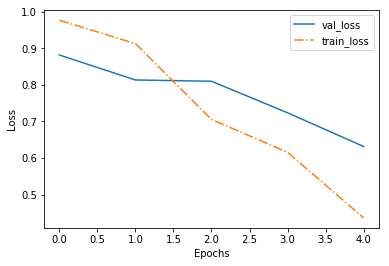

In [70]:
# plotting the loss
plt.plot(batch_mean_df.val_loss.values, label='val_loss', ls='-')
plt.plot(batch_mean_df.train_loss.values, label='train_loss', ls='-.')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')

plt.show()

**Load model and test with the final dataset**

In [0]:
# load our pickle batch of data
with open('stored_batches/total_slices_batch6.pkl', 'rb') as f: # also 'total_slices_all.pkl'
  total_slices, total_slices_info = pickle.load(f) # stored_batches/total_slices_batch5
  
# load our model
model = load_model('stored_models_v2/model'+stored_name+'.h5')

In [0]:
# gets our y-values and converts to keras, one hot encoded outputs
def get_y_values(total_slices_info):
  
  y_values = [s[2] for s in total_slices_info]

  y_values = np.array(to_categorical(y_values, 2))
  
  return y_values

In [76]:
np.unique([s[2] for s in total_slices_info], return_counts=True) # look at distribution of patients

(array([0, 1]), array([40, 62]))

In [0]:
# get y values
y_values = get_y_values(total_slices_info)

# turn into a numpy array
total_slices = np.array(total_slices)

In [78]:
## Build function to load and build score on the fly then aggregate

# Split to 10 chunks of 10
sub_arrays = np.split(total_slices[:100], 10)
sub_y_values = np.split(y_values[:100], 10)

score_sum = []
acc_sum = []
# run through model and test
for i in range(len(sub_arrays)):
  sub_array = sub_arrays[i]
  sub_y_value = sub_y_values[i]
  
  score, acc = model.evaluate(sub_array, sub_y_value)
  score_sum.append(score)
  acc_sum.append(acc)
  
# get average values
mean_score = np.mean(score_sum)
mean_acc = np.mean(acc_sum)

print ("The score of the model: %f, The accuracy of the model: %f" % (mean_score, acc))

10/10 [==============================] - 27s 3s/step
The score of the model: 0.840577, The accuracy of the model: 0.400000
